In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from datetime import timedelta

def identify_low_points(df, min_days=2):
    """
    Identifies time intervals from the latest date back to progressively earlier low points.
    Each interval starts at an identified low point and extends forward to the maximum date.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing at least 'Date' and 'Balance' columns
    min_days : int, default=2
        Minimum number of days for a valid time span

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the low points and their time spans
    """
    # Make a copy to avoid modifying the original
    df = df.copy()

    # Ensure Date column is datetime type
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        df['Date'] = pd.to_datetime(df['Date'])

    # Sort DataFrame chronologically
    df = df.sort_values('Date')

    # Get the maximum date in the dataset (end of all intervals)
    max_date = df['Date'].max()
    min_date = df['Date'].min()

    # Find local minima (low points) in reverse chronological order
    dates = df['Date'].tolist()
    balances = df['Balance'].tolist()

    local_minima = []
    for i in range(len(df) - 1, -1, -1):  # Iterate from end to start
        current_date = dates[i]
        current_balance = balances[i]

        # Skip the maximum date (we'll always end there)
        if current_date == max_date:
            continue

        # Check if this is a local minimum by looking at adjacent points
        is_local_min = True

        # Check if the current point is lower than all future points
        for j in range(i + 1, len(df)):
            if balances[j] < current_balance:
                is_local_min = False
                break

        if is_local_min:
            local_minima.append((current_date, current_balance))

    # Sort local minima from latest to earliest
    local_minima.sort(key=lambda x: x[0], reverse=True)

    # Find the absolute minimum for the entire period
    absolute_min_idx = df['Balance'].idxmin()
    absolute_min_date = df.loc[absolute_min_idx, 'Date']
    absolute_min_balance = df.loc[absolute_min_idx, 'Balance']

    # Process local minima to create time intervals
    results = []

    # Add intervals from each low point to max_date
    for i, (low_date, low_balance) in enumerate(local_minima):
        # Start date is the low point
        start_date = low_date

        # End date is always the maximum date
        end_date = max_date

        # Calculate time span
        time_span = (end_date - start_date).days + 1  # +1 to include both start and end dates

        # Check if time span meets minimum requirement
        if time_span >= min_days:
            # Find the minimum balance in this time span
            span_min_balance = df[(df['Date'] >= start_date) &
                                 (df['Date'] <= end_date)]['Balance'].min()

            results.append({
                'LowPointDate': low_date,
                'LowPointBalance': low_balance,
                'StartDate': start_date,
                'EndDate': end_date,
                'TimeSpanDays': time_span #,
                # 'MinimumBalanceInSpan': span_min_balance
            })

    # Always add the full time interval (min_date to max_date)
    # containing the absolute minimum balance
    full_span = (max_date - min_date).days + 1

    # Only add if not already covered by another interval
    # (this happens if the absolute minimum is also a local minimum)
    if absolute_min_date not in [res['LowPointDate'] for res in results]:
        results.append({
            'LowPointDate': absolute_min_date,
            'LowPointBalance': absolute_min_balance,
            'StartDate': min_date,
            'EndDate': max_date,
            'TimeSpanDays': full_span #,
            # 'MinimumBalanceInSpan': absolute_min_balance
        })

    # Convert results to DataFrame and sort by time span (ascending)
    if results:
        result_df = pd.DataFrame(results)
        result_df = result_df.sort_values('TimeSpanDays')
        return result_df
    else:
        return pd.DataFrame(columns=['LowPointDate', 'LowPointBalance',
                                    'StartDate', 'EndDate', 'TimeSpanDays'])


def plot_balance_with_intervals(df, intervals_df):
    """
    Plots the balance trend with highlighted intervals from low points to max date.

    Parameters:
    -----------
    df : pandas.DataFrame
        Original DataFrame with 'Date' and 'Balance' columns
    intervals_df : pandas.DataFrame
        DataFrame returned by identify_low_points function
    """
    plt.figure(figsize=(12, 8))

    # Plot balance trend
    plt.plot(df['Date'], df['Balance'], 'b-', label='Balance', linewidth=2, color="#3d3936")

    # Get a good color palette for the intervals
    colors = ['#ffcccc', '#ccffcc', '#ccccff', '#ffffcc', '#ffccff', '#ccffff']

    # # Sorted intervals from shortest to longest
    # sorted_intervals = intervals_df.sort_values('TimeSpanDays')

    # ax = plt.gca()
    # legend_handles = [plt.Line2D([0], [0], color='b', lw=2, label='Balance')]

    # # Plot each interval with progressively lighter opacity for longer intervals
    # for i, row in enumerate(sorted_intervals.itertuples()):
    #     # Generate a color for this interval
    #     color_idx = i % len(colors)

    #     # Adjust opacity based on interval length (shorter intervals are more opaque)
    #     base_opacity = 0.7
    #     opacity = max(0.15, base_opacity - (i * 0.1))

    #     # Add a rectangle for the interval
    #     start_date = row.StartDate
    #     end_date = row.EndDate
    #     min_balance = df[df['Date'].between(start_date, end_date)]['Balance'].min()
    #     max_balance = df[df['Date'].between(start_date, end_date)]['Balance'].max()

    #     # Add padding to the rectangle
    #     height_pad = (max_balance - min_balance) * 0.1
    #     y_min = min_balance - height_pad
    #     height = (max_balance - min_balance) + 2 * height_pad

    #     # Make rectangle span from start date to end date
    #     width = (end_date - start_date).total_seconds() / (24 * 3600)  # Convert to days

    #     rect = Rectangle((mdates.date2num(start_date), y_min), width, height,
    #                      color=colors[color_idx], alpha=opacity,
    #                      label=f'Interval {i+1}: {row.TimeSpanDays} days')
    #     ax.add_patch(rect)
    #     legend_handles.append(rect)

    #     # Mark the low point
    #     plt.plot(row.LowPointDate, row.LowPointBalance, 'ro', markersize=8)

    #     # Add text label for the low point
    #     plt.text(row.LowPointDate, row.LowPointBalance - height_pad/2,
    #              f"  Low {i+1}: {row.LowPointBalance}",
    #              fontsize=9, verticalalignment='top')

    # Format the plot
    plt.title('Asset Class Capital Cap', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Balance', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Format x-axis date labels
    plt.gcf().autofmt_xdate()
    date_format = mdates.DateFormatter('%Y-%m-%d')
    plt.gca().xaxis.set_major_formatter(date_format)

    # Add legend
    # plt.legend(handles=legend_handles, loc='upper right')
    plt.tight_layout()
    return plt


# Example usage
if __name__ == "__main__":


    # Load the data
    running_balances = pd.read_pickle('running_balances.pkl')
    df = running_balances[
        (running_balances['TransactionClass'] == 'Certificate of Deposit') &
        (running_balances['TransactionDate'] <= '2025-06-30') &
        (running_balances['TransactionDate'] > '2025-01-21')
    ][['TransactionDate', 'Available']].rename(
        columns={'TransactionDate': 'Date', 'Available': 'Balance'}
    )


    # Apply the function
    result = identify_low_points(df)
    pd.set_option('display.max_rows', None)

    # print("Identified Time Intervals:")
    with pd.option_context('display.float_format', lambda x: f'{x/1e6:.2f}M',
                          'display.max_rows', None,
                          'display.max_columns', None,
                          'display.width', None):
        # print(result.sort_values('StartDate', ascending=True))
        result.sort_values('StartDate', ascending=True)

In [41]:
# Set display options to show all rows and format numbers as millions
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: f'{x/1e6:.2f}M')

# Display the full result DataFrame
result.sort_values('StartDate', ascending=True)


,LowPointDate,LowPointBalance,StartDate,EndDate,TimeSpanDays
33,2025-01-27,23.57M,2025-01-27,2025-06-30,155
32,2025-01-28,25.37M,2025-01-28,2025-06-30,154
31,2025-01-29,26.37M,2025-01-29,2025-06-30,153
30,2025-01-30,26.37M,2025-01-30,2025-06-30,152
29,2025-01-31,30.37M,2025-01-31,2025-06-30,151
28,2025-02-01,30.37M,2025-02-01,2025-06-30,150
27,2025-02-02,30.37M,2025-02-02,2025-06-30,149
26,2025-02-03,35.37M,2025-02-03,2025-06-30,148
25,2025-02-05,39.52M,2025-02-05,2025-06-30,146
24,2025-02-06,43.02M,2025-02-06,2025-06-30,145


C:\Users\Adam.Skrzypulec\AppData\Local\Temp\ipykernel_15676\3987847563.py:141: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(df['Date'], df['Balance'], 'b-', label='Balance', linewidth=2, color="#3d3936")


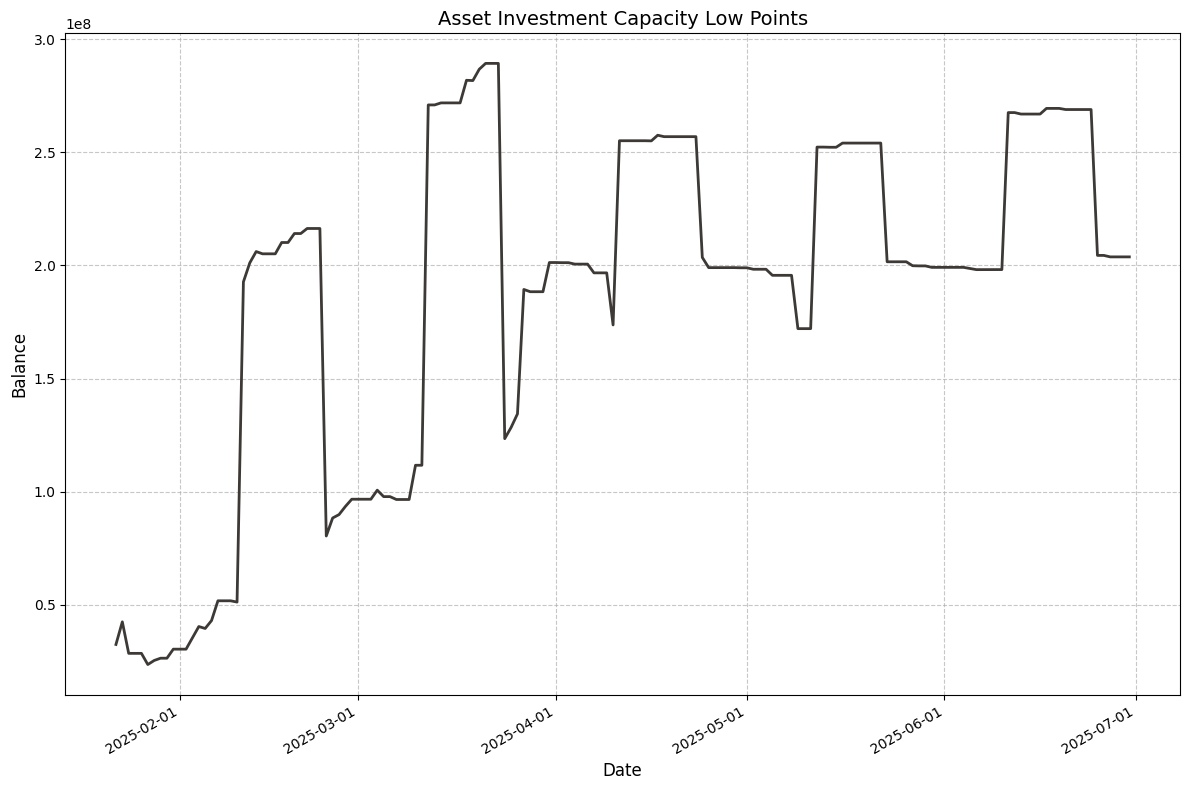

In [42]:
# Plot the balance with intervals
plot = plot_balance_with_intervals(df, result)
plt.show()